# Guided Project: Creating a Kaggle Workflow
We're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.
## Intro
The Titanic dataset is part of a famous beginner competition in Kaggle. It holds information about the passengers of the Titanic and the goal is to create a model that predicts whether a passenger has survived or not, given the information in the training data set.

This problem asks for a classification model to predict the binary target value (`Survived` or `Died`).

### Import standard libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load the data set

In [2]:
# load the csv files
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
# inspect the data frames
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [6]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The holdout data set to test our model on for Kaggle does not contain the target column (`Survived`).

### Import helpful functions created earlier and create functions for this workflow
We can use the "magic command" `%load` to load an external python file. This external file contains functions we have used before.

In [7]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [8]:
# create a function that combines the above listed functions and uses them on a data frame
def process_titanic_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, col)

    return df

In [9]:
# Apply the function on training and holdout data sets
train = process_titanic_df(train)
holdout = process_titanic_df(holdout)

In [10]:
# check training data frame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

In [11]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
#import pandas_profiling

#train.profile_report()

# does not work in data quest notebook environment

We now have many more columns in the data set after the processing took place.

## Data Exploration
We will have a look at the two columns `SibSp` and `Parch`, which give information about family members on the Titanic for each passenger.
* `SibSp`: number of siblings / spouses aboard the Titanic
* `Parch`: number of parents / children aboard the Titanic	

In [12]:
train[['SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


In [13]:
train[['SibSp', 'Parch']].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


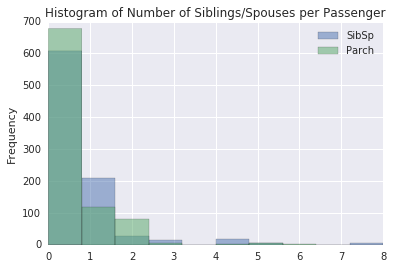

In [14]:
train[['SibSp', 'Parch']].plot(kind='hist', alpha=0.5, title='Histogram of Number of Siblings/Spouses per Passenger')

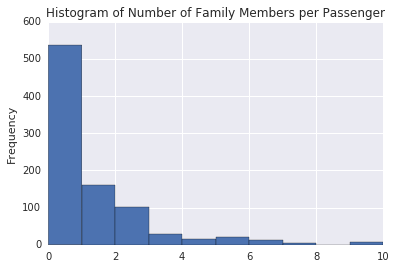

In [15]:
combination_col = train.copy()
combination_col['FamMem'] = train[['Parch', 'SibSp']].sum(axis=1)
combination_col['FamMem'].plot(kind='hist', title='Histogram of Number of Family Members per Passenger')

We can see from the data overview and the histograms of the columns that most passengers of the Titanic did not have any family members on board with them. It might be interesting to find out whether this correlates with the passenger classes (expensive classes have family members while cheap classes travel alone?).

In general both features are skewed right.

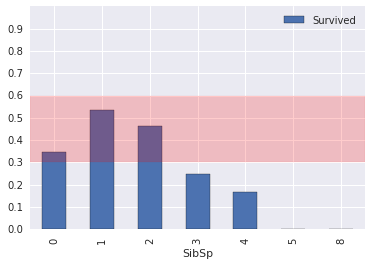

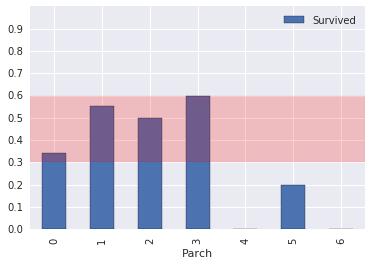

In [16]:
#create pivot tables per column with percentage of survived per attribute
for col in ['SibSp', 'Parch']:
    pivot = train.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

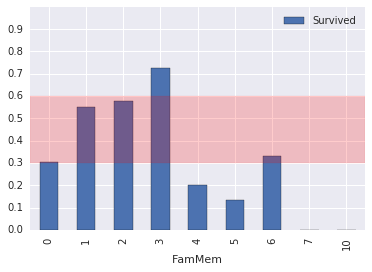

In [17]:
pivot = combination_col.pivot_table(index='FamMem',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.axhspan(.3, .6, alpha=0.2, color='red')
plt.show()

Looking at the survival rates of the the combined family members, you can see that only few of the over 500 passengers with no family members survived (about 30%), while greater numbers of passengers with family members survived.

## Feature Engineering
Based of the family members exploration, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

* `1` if the passenger has zero family members onboard
* `0` if the passenger has one or more family members onboard

In [18]:
def isalone(df):
    df['isalone'] = df[['Parch', 'SibSp']].sum(axis=1).apply(lambda x: 0 if x==0 else 1)
    return df

In [19]:
train = isalone(train)
holdout = isalone(holdout)

In [20]:
train.isalone.value_counts()

0    537
1    354
Name: isalone, dtype: int64

## Feature Selection
We can use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [22]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



We now have a set of features we can use for the Random Forest model. You can notice multicollinearity within the data. This is not affecting the predictions of Random Forest models.

## Model Selection and Tuning
Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [24]:
models_features = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    },
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    },
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(random_state=1),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]

            }
    }
]

In [31]:
def select_model(df, features, target, models_features):
    """
    Selects best performing model for given data set via grid search.
    
    Args:
        df (DataFrame): The training data set.
        features (list): The columns used as features.
        target (string): The target column.
        models_features (list of dictionaries): A list of dictionaries, each containing a model name, its estimator and a dictionary of hyperparameters.

    Returns:
        models_features: The enhanced input list of dictionaries
    """
    # split data frame into features and target data frames/series
    all_X = df[features]
    all_y = df[target]
    
    for model in models_features:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['parameters'] = grid.best_params_
        model['score'] = grid.best_score_
        model['estimator'] = grid.best_estimator_
        print("Best Score: {}".format(model["score"]))
        print("Best Parameters: {}\n".format(model["parameters"]))
    return models_features

In [32]:
result = select_model(train, cols, 'Survived', models_features)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'n_neighbors': 5, 'algorithm': 'brute', 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8372615039281706
Best Parameters: {'n_estimators': 9, 'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 'log2', 'min_samples_split': 5, 'max_depth': 10}



## Save Submission CSV for Kaggle
If we're going to be continually submitting improved models to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [40]:
def save_submission_file(model, columns, filename='submission.csv'):
    predictions = model.predict(holdout[columns])
    submission_df = pd.DataFrame({'PassengerID': holdout['PassengerId'],
                                  'Survived': predictions})
    submission_df.to_csv(filename)

In [41]:
best_model = result[2]['estimator']

In [42]:
save_submission_file(best_model, cols, 'titanic_submission_01.csv')